In [1]:

from sys import path
path.append('/u/cm/rbertoss')



In [2]:
import thermocepstrum as tc

In [3]:
import thermocepstrum.blockanalysis as ba

In [4]:
import imp

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

In [6]:
jfile = tc.io.LAMMPS_Current('dump1400_18ns.log', group_vectors=True)

#scopo di questo file: continuare una simulazione precedente con T=1400K
#
echo both
read_restart equil.${T_resume}.restart
read_restart equil.1400.restart
  orthogonal box = (-3.17721 -3.17721 -3.17721) to (37.0343 37.0343 37.0343)
  2 by 2 by 3 MPI processor grid
  1728 atoms
kspace_style ewald 0.01e-5
pair_style born/coul/long 20.0
variable b equal 0.211
variable A11 equal 1.25*$b
variable A11 equal 1.25*0.211
variable A12 equal 1.0*$b
variable A12 equal 1.0*0.211
variable A22 equal 0.75*$b
variable A22 equal 0.75*0.211
variable rho equal 0.317
variable sigma1 equal 1.17
variable sigma2 equal 1.585
variable C11 equal 1.04857
variable C12 equal 6.99049
variable C22 equal 72.4015
variable D11 equal -0.499321
variable D12 equal -8.6757
variable D22 equal -145.427
variable sigma11 equal ${sigma1}*2
variable sigma11 equal 1.17*2
variable sigma12 equal ${sigma1}+${sigma2}
variable sigma12 equal 1.17+${sigma2}
variable sigma12 equal 1.17+1.585
variable sigma22 equal ${sigma2}*2
variable si

In [7]:
jfile.read_currents(NSTEPS=3600000, start_step=0, select_ckeys = ['flusso', 'vcm[1]','vcm[2]','Temp','Lx','Time'])

  ckey =  {'Temp': [6], 'flusso': array([7, 8, 9]), 'Time': [1], 'vcm[2]': array([13, 14, 15]), 'vcm[1]': array([10, 11, 12]), 'Lx': [4]}
    step =    100000 -   2.78% completed
    step =    200000 -   5.56% completed
    step =    300000 -   8.33% completed
    step =    400000 -  11.11% completed
    step =    500000 -  13.89% completed
    step =    600000 -  16.67% completed
    step =    700000 -  19.44% completed
    step =    800000 -  22.22% completed
    step =    900000 -  25.00% completed
    step =   1000000 -  27.78% completed
    step =   1100000 -  30.56% completed
    step =   1200000 -  33.33% completed
    step =   1300000 -  36.11% completed
    step =   1400000 -  38.89% completed
    step =   1500000 -  41.67% completed
    step =   1600000 -  44.44% completed
    step =   1700000 -  47.22% completed
    step =   1800000 -  50.00% completed
    step =   1900000 -  52.78% completed
    step =   2000000 -  55.56% completed
    step =   2100000 -  58.33% completed
 

{'Lx': array([[ 40.211549],
        [ 40.211549],
        [ 40.211549],
        ..., 
        [ 40.211549],
        [ 40.211549],
        [ 40.211549]]), 'Temp': array([[ 1398.6728],
        [ 1398.1767],
        [ 1398.5811],
        ..., 
        [ 1405.6486],
        [ 1395.482 ],
        [ 1382.5869]]), 'Time': array([[  5.00000000e-03],
        [  1.00000000e-02],
        [  1.50000000e-02],
        ..., 
        [  1.79999900e+04],
        [  1.79999950e+04],
        [  1.80000000e+04]]), 'flusso': array([[  43.61428 ,  476.73654 , -330.84389 ],
        [  97.499211,  397.35175 , -337.05882 ],
        [ 180.98051 ,  294.01742 , -327.5384  ],
        ..., 
        [ 183.89699 ,  247.42873 , -110.79515 ],
        [ 249.18835 ,  321.71807 , -126.82791 ],
        [ 329.66691 ,  370.35781 , -153.65562 ]]), 'vcm[1]': array([[-0.29884737, -0.12877547,  0.16692061],
        [-0.33646256, -0.08719853,  0.0921912 ],
        [-0.37818073, -0.05012228,  0.02831954],
        ..., 
        [ 0

In [8]:
DT_FS=(jfile.data['Time'][1]-jfile.data['Time'][0])*1000
TEMPERATURE=0.0
cont=0
for T in jfile.data['Temp']:
    cont=cont+1
    delta=T-TEMPERATURE
    TEMPERATURE=TEMPERATURE+delta/cont
VOLUME=jfile.data['Lx'][0]**3
kappa_scale = tc.md.scale_kappa_METALtoSI(TEMPERATURE, VOLUME, DT_FS)
print 'kappa_scale = {}, T={}K, DT_FS={}fs, V={}Å³'.format(kappa_scale,TEMPERATURE,DT_FS,VOLUME)
#sanity check
oldt=jfile.data['Time'][0]-(jfile.data['Time'][1]-jfile.data['Time'][0])
for t in jfile.data['Time']:
    if abs(t-oldt - (jfile.data['Time'][1]-jfile.data['Time'][0]) )> 0.0001:
        print 'Sanity check failed between times: ',oldt,t
    oldt=t

kappa_scale = [  7.31020658e-07], T=[ 1398.49999348]K, DT_FS=[ 5.]fs, V=[ 65020.81502498]Å³


In [9]:
JZ = jfile.data['vcm[1]']-jfile.data['vcm[2]']

In [10]:
imp.reload(ba)

<module 'thermocepstrum.blockanalysis' from '/u/cm/rbertoss/thermocepstrum/blockanalysis.pyc'>

In [11]:
TSKIP          = 6       # time step [DT_FS]
FILTER_WIDTH_T = TSKIP    # filter window width [DT = 1.0fs]
BLOCK_SIZE_T   = int(50000/DT_FS) # block width [DT_FS] = 100 ps

b = ba.MDBlocks(jfile.data['flusso'], DT_FS, TSKIP, FILTER_WIDTH_T, T, VOLUME, 'metal', GUI=True)
b.segment_trajectory(BLOCK_SIZE_T)
bz = ba.MDBlocks(JZ, DT_FS, TSKIP, FILTER_WIDTH_T, T, VOLUME, 'metal', GUI=True)
bz.segment_trajectory(BLOCK_SIZE_T)

 TOT_TIME     = (600000, 3)
 NYQUIST_F    = 0.0833333333333 = [ 16.66666667] THz
 BLOCK_SIZE   =       1666
 N_BLOCKS     =        360
 TOT_TIME     = (600000, 3)
 NYQUIST_F    = 0.0833333333333 = [ 16.66666667] THz
 BLOCK_SIZE   =       1666
 N_BLOCKS     =        360


In [12]:
b.cepstral_analysis_kappa(other=bz,Kmin_corrfactor=1.) #, bayes_p=True, density_grid=DENSITY_GRID)
b.compute_averages()


 N_COMPONENTS =          3


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



   min(psd)           =       15.1429
   max[AIC_Kmin]      =            18
   AIC_Kmin           =         4.639 +/- 2.445538

   flogtau[@AIC_Kmin] =     13.106436 +/- 0.106789  (SW p-value = 0.000017)
   ftau[@AIC_Kmin]    =  881484.866904 +/- 94133.280567
   FTAU[@AIC_Kmin]    =  [ 0.32965114] +/- [ 0.03520326]

   THEORY_STD_flogtau[@ave_AIC_Kmin] =    0.0922850816596  (errcheck: 0.0873750958899 +/- 0.0179711544035)
   THEORY_STD_ftau[@ave_AIC_Kmin]    =    81347.902924
   THEORY_STD_FTAU[@ave_AIC_Kmin]    =    [ 0.03042188]



In [13]:
#kappa_Kmin = jf.dct.tau_Kmin * kappa_scale
#kappa_std_Kmin = jf.dct.tau_std_Kmin * kappa_scale
#print 'kappa* = {} +/- {}  W/mK'.format(kappa_Kmin, kappa_std_Kmin)




In [105]:
def PSD(i):
    psd=np.array(list(b.spsd()))[i]
    return psd, psd.mean()
def logPSD(i):
    psd=np.array(list(b.slogpsd()))[i]
    return psd, psd.mean()
def all_PSD(maxi):
    tmp,media = PSD(1)
    res=tmp
    for i in range(2,maxi):
        mp,media = PSD(i)
        res=np.concatenate((res,mp/media))
    return res.flatten()
def all_logPSD(maxi):
    tmp,media = logPSD(1)
    res=tmp
    for i in range(2,maxi):
        mp,media = logPSD(i)
        res=np.concatenate((res,mp-media))
    return res.flatten()

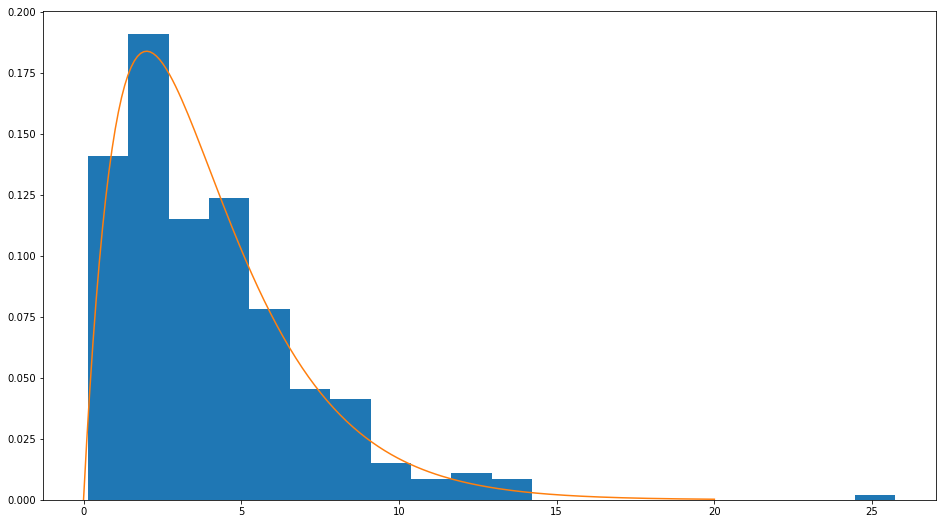

In [120]:
x=np.linspace(0,20,200)
psd_,mean_=PSD(1)
plt.hist(psd_*4/mean_, bins=20,normed='probability')
plt.plot(x,np.exp(-x/2)*x/4)

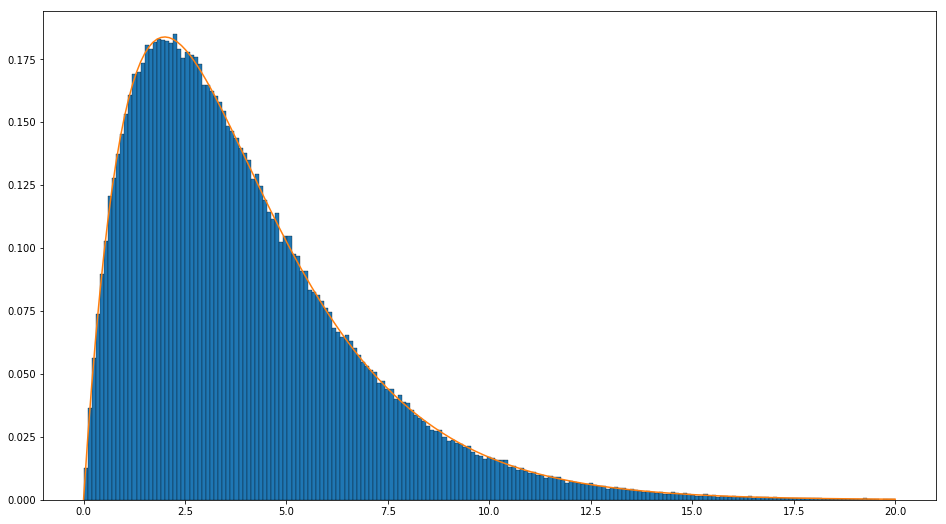

In [107]:
x=np.linspace(0,20,200)
plt.hist(all_PSD(800)*4, bins=x, ec='k', lw=0.3, align='mid',alpha=1,normed='probability')
plt.plot(x,np.exp(-x/2)*x/4)

In [108]:
import scipy as sp

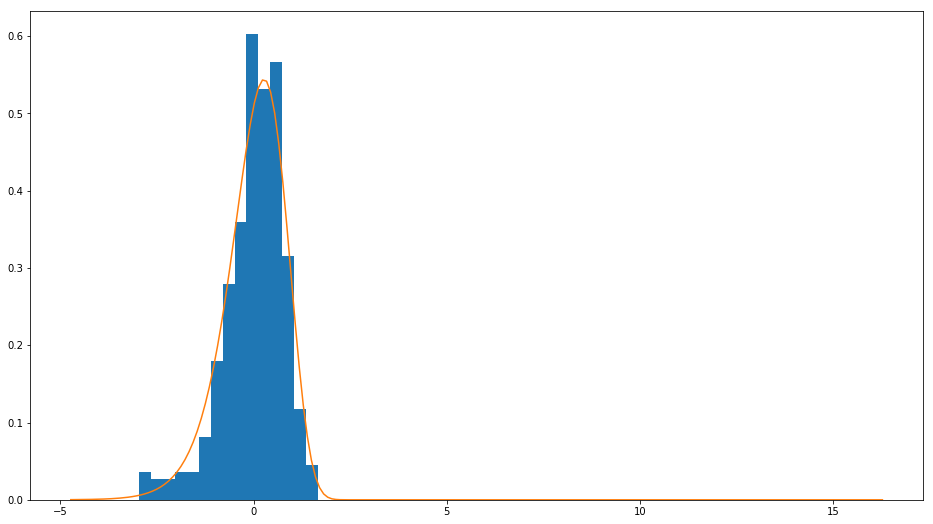

In [128]:
logpsd,media=logPSD(600)
plt.hist(logpsd-media,normed='probability', bins=15)
x=np.linspace(-5,16,200)
y=4*np.exp(-2*np.exp(x)+2*x)
y=y/(np.sum(y)*((x[-1]-x[0])/x.size))
plt.plot(x+np.log(2)- sp.special.digamma(2) , y)

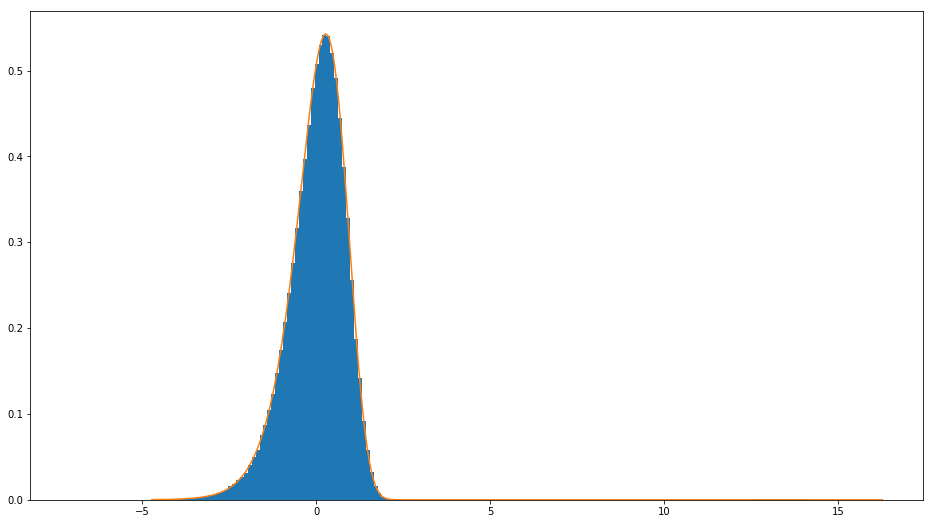

In [127]:
logpsd=all_logPSD(800)
plt.hist(logpsd,normed='probability', bins=200)
x=np.linspace(-5,16,400)
y=4*np.exp(-2*np.exp(x)+2*x)
y=y/(np.sum(y)*((x[-1]-x[0])/x.size))
plt.plot(x+np.log(2)- sp.special.digamma(2) , y)